Acquisition and Analysis of Neural Data 

Exercise 03

Bramantyo Ibrahim Supriyatno

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import eig

import seaborn as sns
import scipy.io

sns.set(style="darkgrid", context="talk", palette="pastel")
plt.style.use('dark_background')

# Exercise 1

In [2]:
spike_times = np.loadtxt('SpikeTimes.dat').T/1e3
#spike_times = np.nan_to_num(spike_times, nan=-1)
max_t = 5.5
del_t = 1e-4
num_trial = 100
sr = int(1./del_t)
num_samples = int(max_t*sr)
t = np.arange(0, max_t, step=del_t)

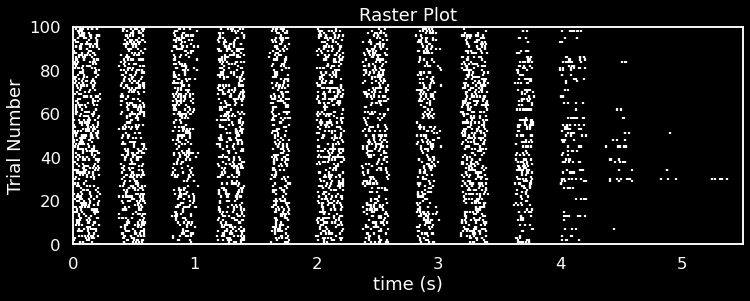

In [3]:
plt.figure(figsize=(12,4))
plt.eventplot(spike_times)
plt.xlim(0, max_t)
plt.ylim(0, num_trial)
plt.title('Raster Plot')
plt.ylabel('Trial Number')
plt.xlabel('time (s)')
plt.grid()
plt.show()

In [4]:
def plot_isi_hist(spike_times, title='Interspike Interval Histogram', num_bins=200, num_trial = 1):
    spike_diff = np.diff(spike_times).ravel()
    spike_diff = spike_diff[~np.isnan(spike_diff)]

    counts, bins = np.histogram(spike_diff, num_bins)
    trial_norm_counts = counts/num_trial
    plt.figure(figsize=(12,4))
    plt.hist(bins[:-1], bins, weights=trial_norm_counts)
    plt.xlabel('ISI (s)')
    plt.ylabel('Counts')
    plt.title(title)
    plt.grid()
    plt.show()

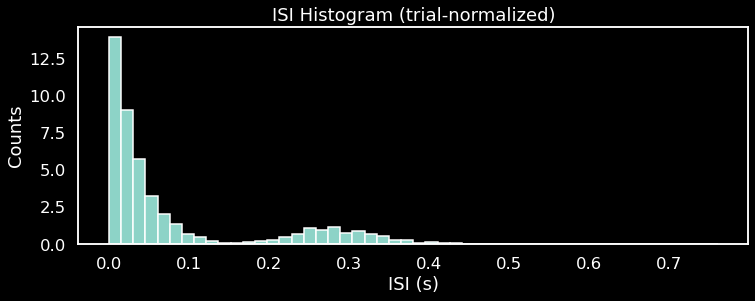

In [5]:
plot_isi_hist(spike_times, title='ISI Histogram (trial-normalized)', num_trial=num_trial, num_bins=50)

the interspike interval are mostly concentrated at 0 second. there is however a significant distribution at 0.3 second which explains the gap that can be seen on the raster plot.

In [6]:
def get_cv(spike_times):
    spike_diff = np.diff(spike_times).ravel()
    spike_diff = spike_diff[~np.isnan(spike_diff)]

    return spike_diff.std()/spike_diff.mean()

In [7]:
print('trial pooled CV: {}'.format(get_cv(spike_times)))

trial pooled CV: 1.3537882337148048


In [8]:
def time_to_dirac(data, num_trial, num_samples, del_t):
    data_pp = np.nan_to_num(data, nan=-1)
    spike_del = np.zeros((num_trial,num_samples))

    for i in range(num_trial):
        temp_idx = data_pp[i,:]
        temp_idx = temp_idx[temp_idx > 0]
        temp_idx = (temp_idx / del_t).astype(int)
        spike_del[i,temp_idx] = 1
    
    return spike_del

In [9]:
spike_dirac = time_to_dirac(spike_times, num_trial, num_samples, del_t)

In [10]:
def fano_factor(dirac_data, wsize_s, num_trial, num_samples, del_t, is_trial_resolve = False):
    if is_trial_resolve:
        ax = 1
    else:
        ax = 0

    wsize = int(wsize_s / del_t)
    num_window = int(num_samples / wsize)
    ns = []
    for i  in range(num_window):
        window = dirac_data[:,i*wsize:(i+1)*wsize]
        n = np.sum(window, axis=1)
        ns.append(n)
    ns = np.array(ns).T
    trial_mean = np.mean(ns, axis = ax)
    trial_var = np.var(ns, axis = ax) 
    return np.divide(trial_var, trial_mean)
    

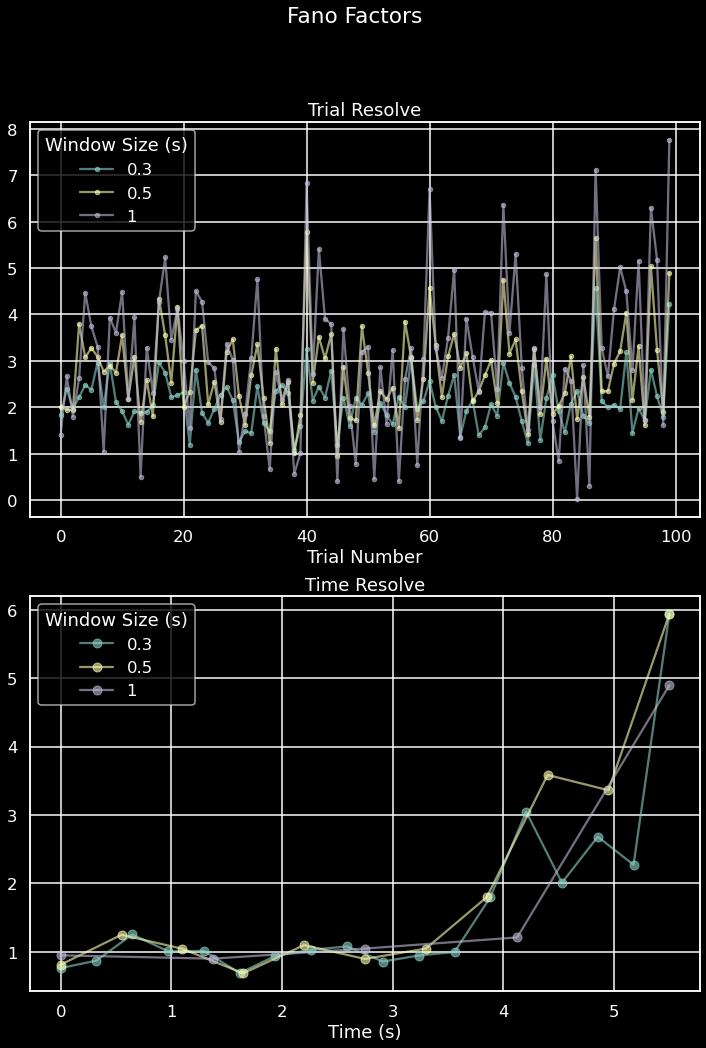

In [11]:
wsizes = [0.3, 0.5, 1]

fig, ax = plt.subplots(2,1, figsize=(12,16))
fig.suptitle('Fano Factors')
for wsize in wsizes:
    time_res = fano_factor(spike_dirac, wsize, num_trial, num_samples, del_t)
    trial_res = fano_factor(spike_dirac, wsize, num_trial, num_samples, del_t, True)
    ax[0].plot(trial_res, marker='.', label=str(wsize), alpha=0.6)

    t = np.linspace(0, max_t, time_res.shape[0])
    ax[1].plot(t, time_res, marker='o', label=str(wsize), alpha=0.6)
ax[0].set_title('Trial Resolve')
ax[0].set_xlabel('Trial Number')
ax[0].legend(title='Window Size (s)')

ax[1].set_title('Time Resolve')
ax[1].set_xlabel('Time (s)')
ax[1].legend(title='Window Size (s)')

plt.show()

Discussion:

Fano factor 

# Exercise 2

In [12]:
mat_data = scipy.io.loadmat('PoissonSpikeTrains.mat')

spike_times_hom = mat_data['SpikeTimes_hom']/1e3
spike_times_inh = mat_data['SpikeTimes_inh']/1e3

max_t_hom = spike_times_hom.max()
max_t_inh = spike_times_inh.max()

del_t = 1e-4

num_samples_hom = int(np.ceil(max_t_hom / del_t))
num_samples_inh = int(np.ceil(max_t_inh / del_t))

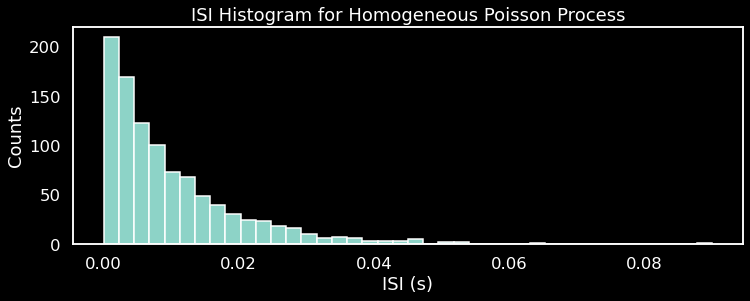

In [13]:
plot_isi_hist(spike_times_hom, num_bins=40, title='ISI Histogram for Homogeneous Poisson Process')

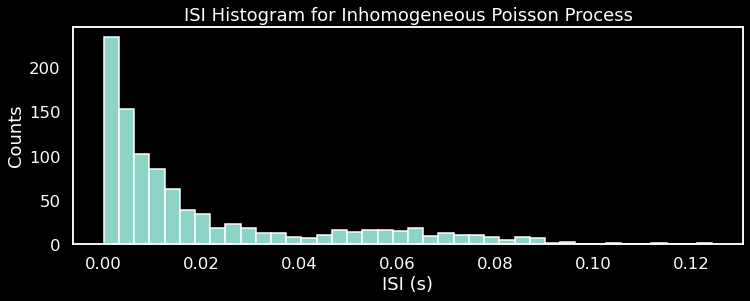

In [14]:
plot_isi_hist(spike_times_inh, num_bins=40, title='ISI Histogram for Inhomogeneous Poisson Process')

In [15]:
print('CV for Homogeneous Poisson Process: {}'.format(get_cv(spike_times_hom)))
print('CV for Inhomogeneous Poisson Process: {}'.format(get_cv(spike_times_inh)))

CV for Homogeneous Poisson Process: 1.0126965180137775
CV for Inhomogeneous Poisson Process: 1.1805742873016383


In [16]:
hom_dirac = time_to_dirac(spike_times_hom, 1, num_samples_hom, del_t)
inh_dirac = time_to_dirac(spike_times_inh, 1, num_samples_inh, del_t)
hom_fano = float(fano_factor(hom_dirac, 0.1, 1, num_samples_hom, del_t, True))
inh_fano = float(fano_factor(inh_dirac, 0.1, 1, num_samples_hom, del_t, True))

print('fano factor of homogeneous poisson process: {}'.format(hom_fano))
print('fano factor of inhomogeneous poisson process: {}'.format(inh_fano))

fano factor of homogeneous poisson process: 1.0760095747095602
fano factor of inhomogeneous poisson process: 1.0834641548927262


In [17]:
hom_firing_rate = np.sum(hom_dirac) / max_t_hom
inh_firing_rate = np.sum(inh_dirac) / max_t_inh
print('average firing rate of homogeneous poisson process: {}'.format(hom_firing_rate))
print('average firing rate of inhomogeneous poisson process: {}'.format(inh_firing_rate))

average firing rate of homogeneous poisson process: 100.74812523960486
average firing rate of inhomogeneous poisson process: 49.42815474865771


In [88]:
def plot_autocorrelation(dirac_deltas, max_t, xlim2=2, ylim2=2, title = 'Autocorrelation'):
    corr = np.correlate(dirac_deltas.ravel(), dirac_deltas.ravel(), 'full') / max_t
    t = np.linspace(-max_t, max_t, corr.shape[0])

    fig, ax = plt.subplots(2,1, figsize=(12,16))
    fig.suptitle(title)
    ax[0].plot(t, corr)
    ax[0].set_xlabel('τ (s)')
    ax[0].set_ylabel('')

    ax[1].plot(t, corr)
    ax[1].set_xlabel('τ (s)')
    ax[1].set_ylabel('')
    ax[1].set_ylim(0,ylim2)
    ax[1].set_xlim(-xlim2,xlim2)

    plt.show()

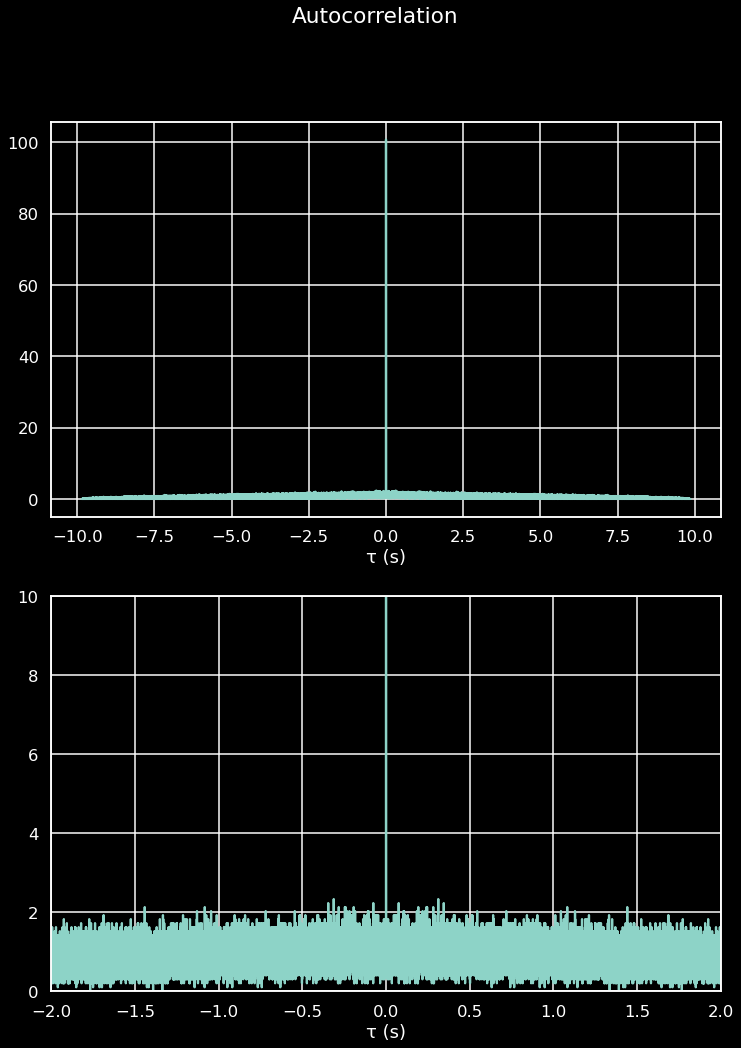

In [89]:
plot_autocorrelation(hom_dirac, max_t_hom, xlim2=2, ylim2=10)

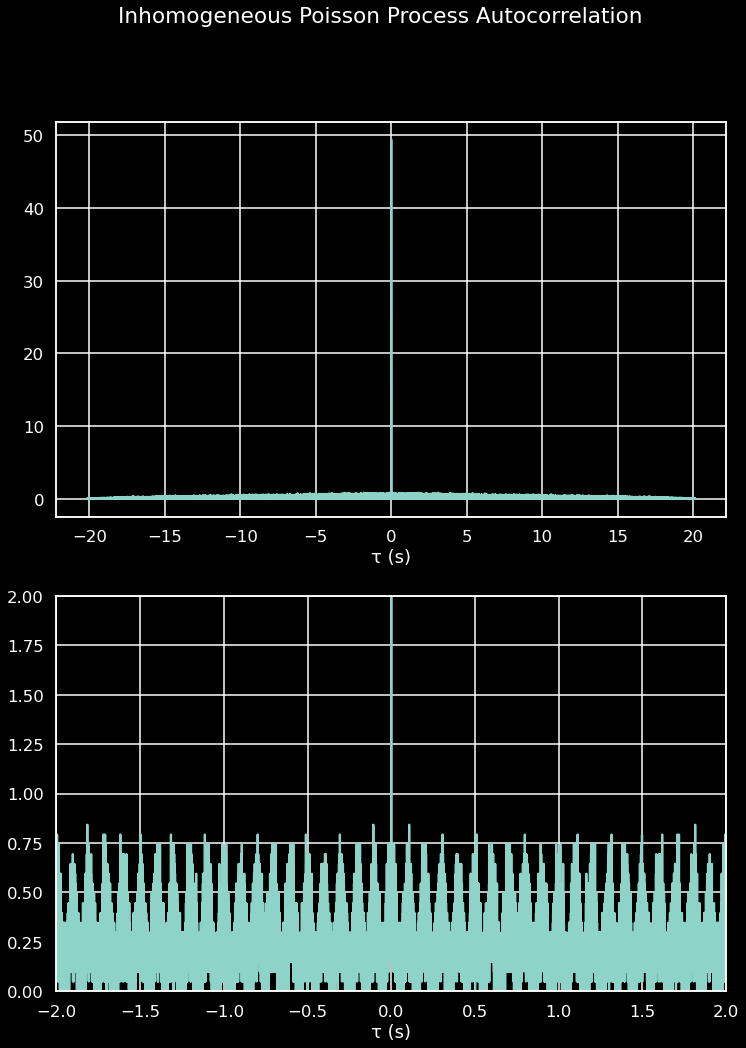

In [91]:
plot_autocorrelation(inh_dirac, max_t_inh, xlim2=2, ylim2=2, title = 'Inhomogeneous Poisson Process Autocorrelation')

remarks about why CV and FANO factor not 1

# Exercise 3

In [26]:
rates_ref = [10, 50, 100, 200, 500, 1000]
del_t = 1e-3
ref_spike_times = scipy.io.loadmat('PoissonSpikeTrains.mat')['SpikeTimes_ref'].T / 1e3
fano_s_size = 0.1

spike_trains = []
ref_diracs = []
max_ts = []
r_effs = []
num_samples = []
cvs = [] 
fanos = []


for i in range (ref_spike_times.shape[0]):
    data =  ref_spike_times[[i],:]
    max_t = data.max()
    num_sample = int(np.ceil(max_t / del_t))
    dirac = time_to_dirac(data, 1, num_sample, del_t)

    spike_trains.append(data)
    max_ts.append(max_ts)
    num_samples.append(num_samples)
    ref_diracs.append(dirac)
    r_effs.append(dirac.sum() / max_t)
    cvs.append(get_cv(data))
    fanos.append(fano_factor(dirac, fano_s_size, 1, num_sample, del_t, True))

In [29]:
r_effs

[9.63473599090632,
 40.39062062912255,
 67.20831374105512,
 100.6081177641577,
 143.35227509871126,
 167.00314574295265]

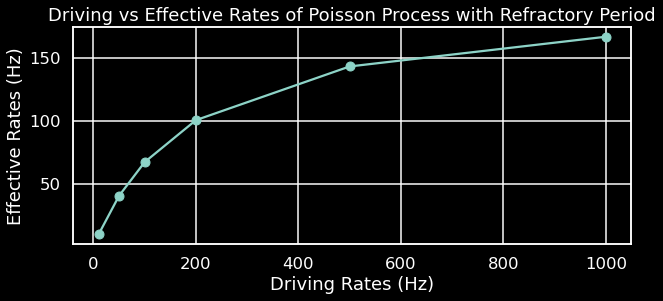

In [22]:
plt.figure(figsize = (10,4))
plt.plot(rates_ref, r_effs, marker='o')
plt.xlabel('Driving Rates (Hz)')
plt.ylabel('Effective Rates (Hz)')
plt.title('Driving vs Effective Rates of Poisson Process with Refractory Period')
plt.show()

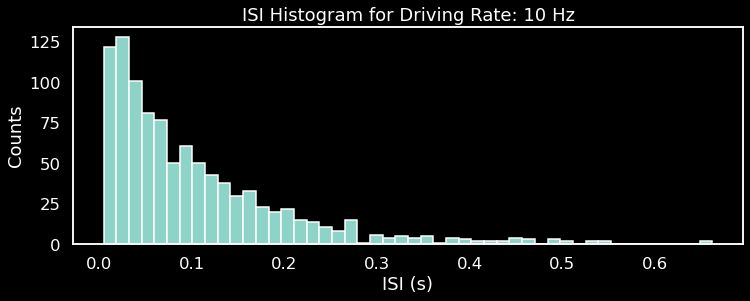

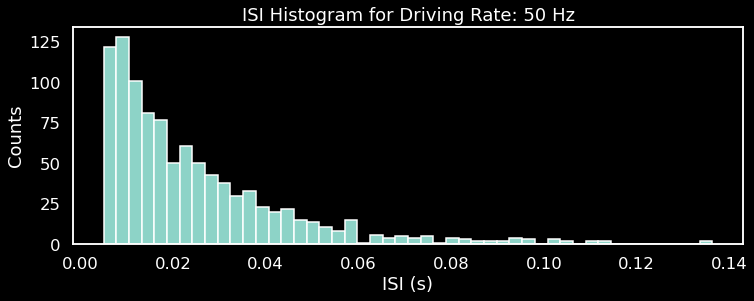

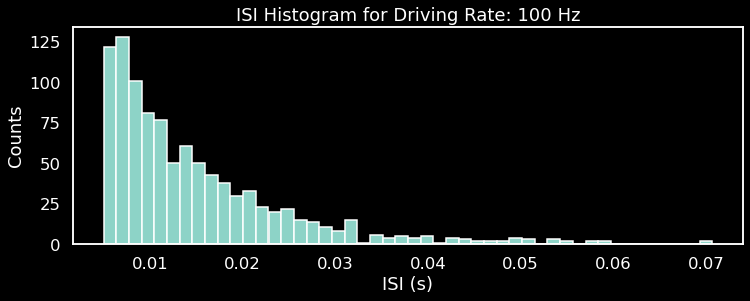

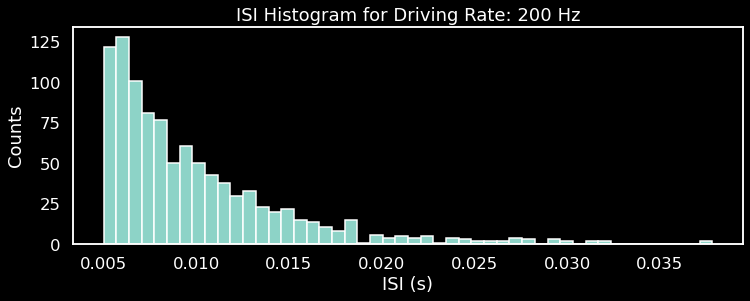

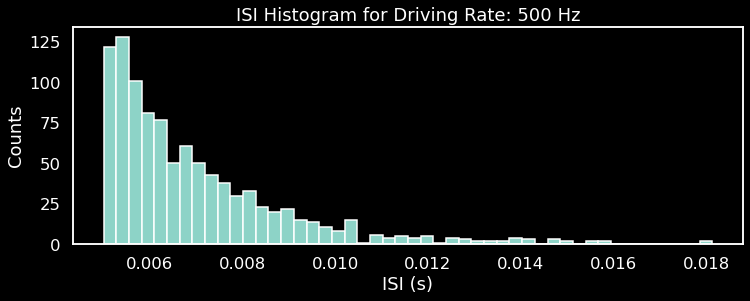

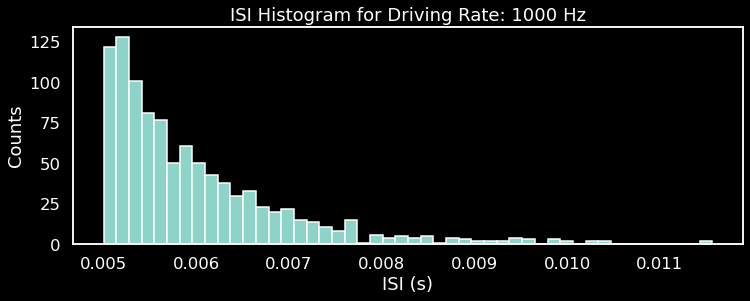

In [23]:

for i,st in enumerate(spike_trains):
    plot_isi_hist(st, num_bins=48, title='ISI Histogram for Driving Rate: {} Hz'.format(rates_ref[i]))
#     # spike_diff = np.diff(spike_times).ravel()
#     # spike_diff = spike_diff[~np.isnan(spike_diff)]

#     counts, bins = np.histogram(np.diff(st),100)
#     trial_norm_counts = counts
    
#     plt.hist(bins[:-1], bins, weights=trial_norm_counts)
# plt.xlabel('ISI (s)')
# plt.ylabel('Counts')
# plt.title('title')
# plt.grid()
# plt.show()

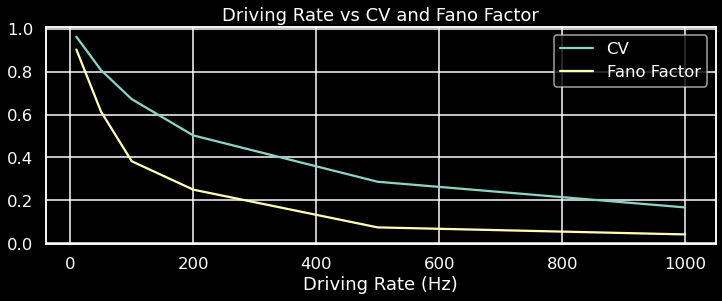

In [24]:
plt.figure(figsize=(12,4))
plt.plot(rates_ref, cvs, label='CV')
plt.plot(rates_ref, fanos, label='Fano Factor')
plt.title('Driving Rate vs CV and Fano Factor')
plt.xlabel('Driving Rate (Hz)')
plt.legend()
plt.show()

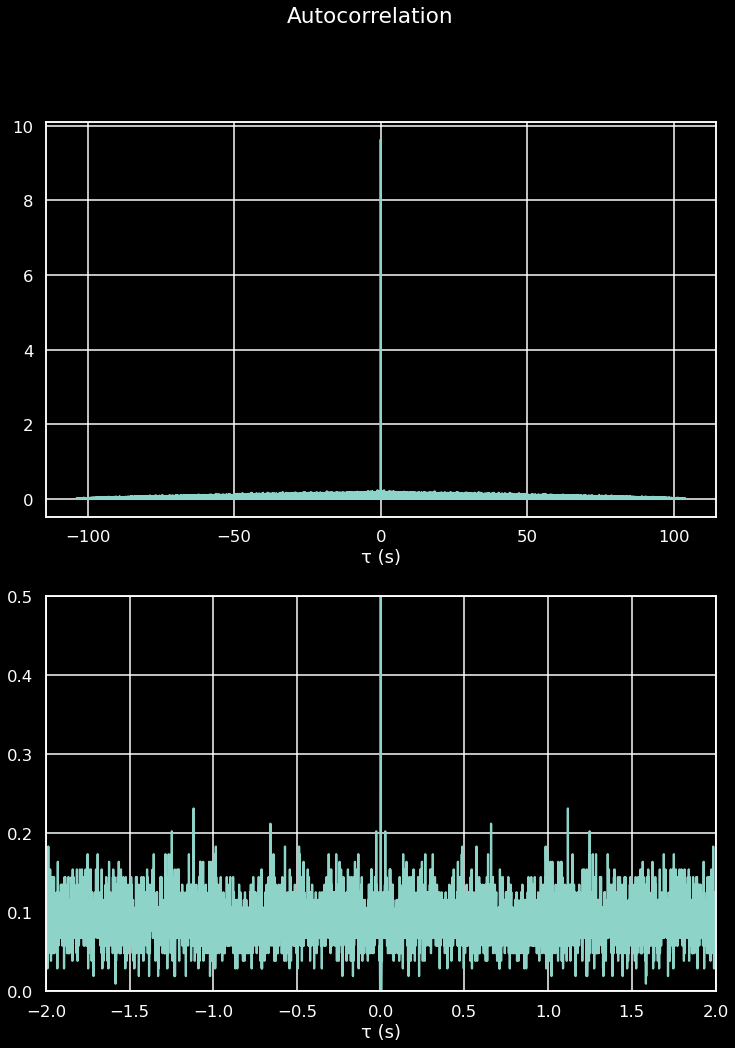

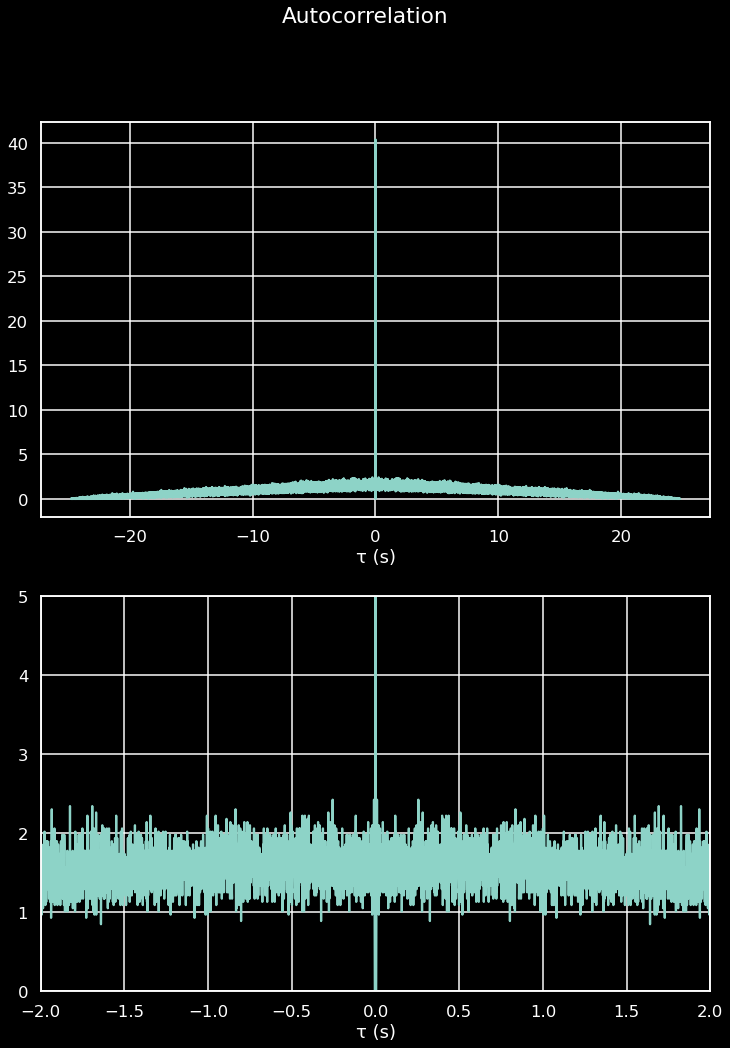

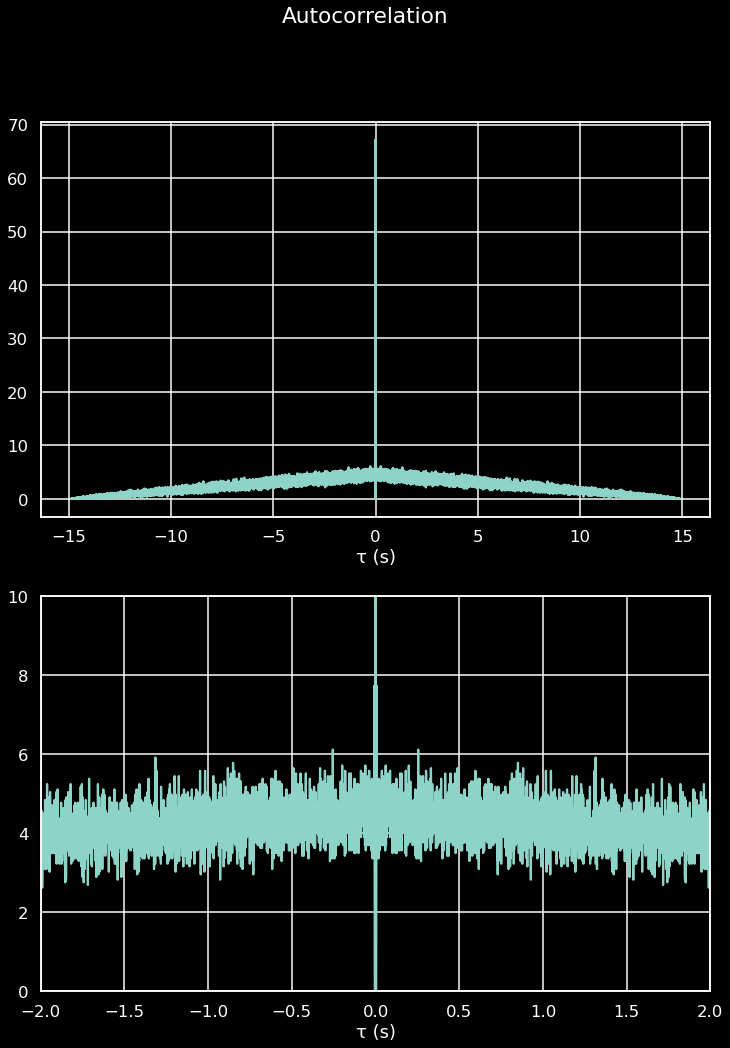

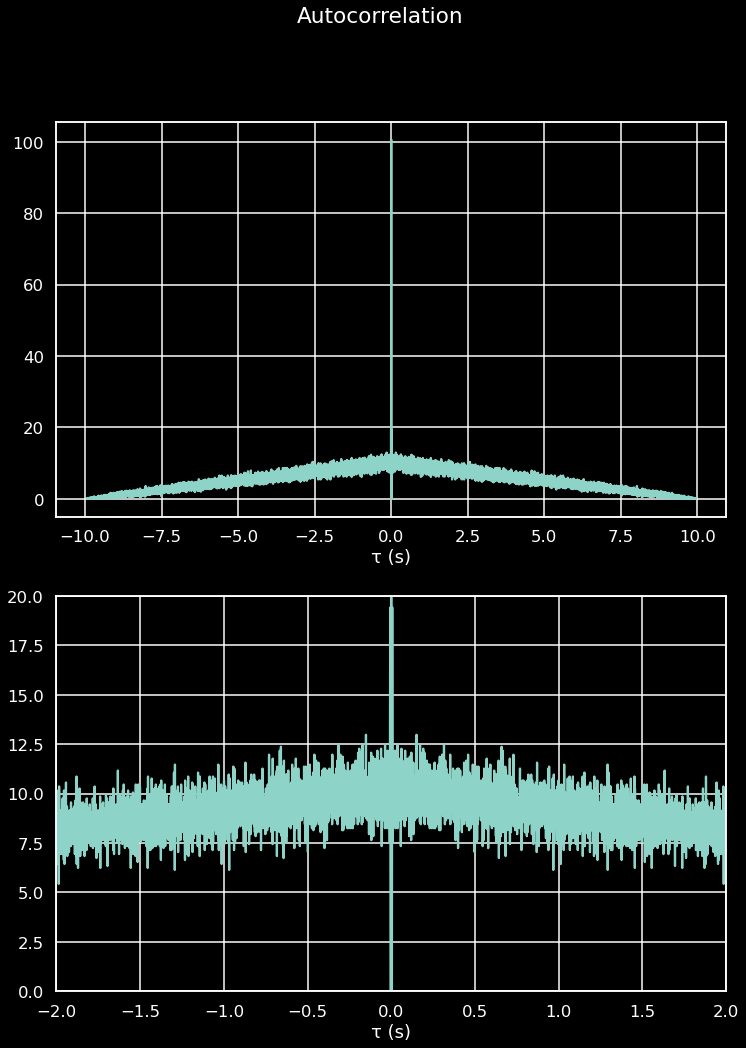

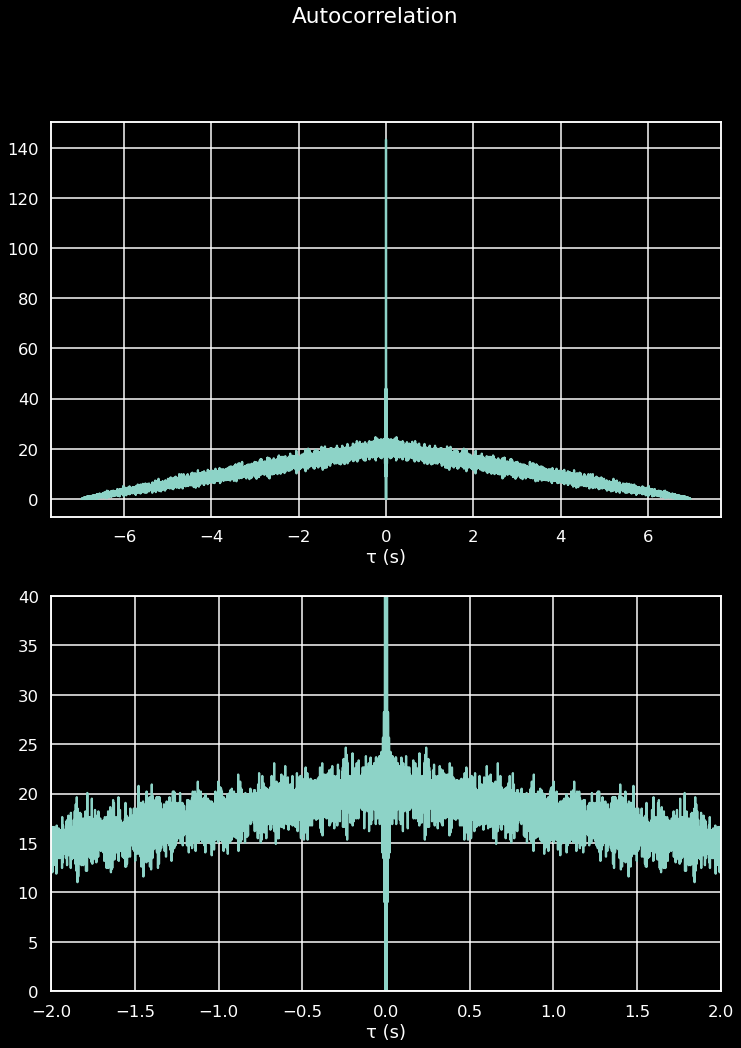

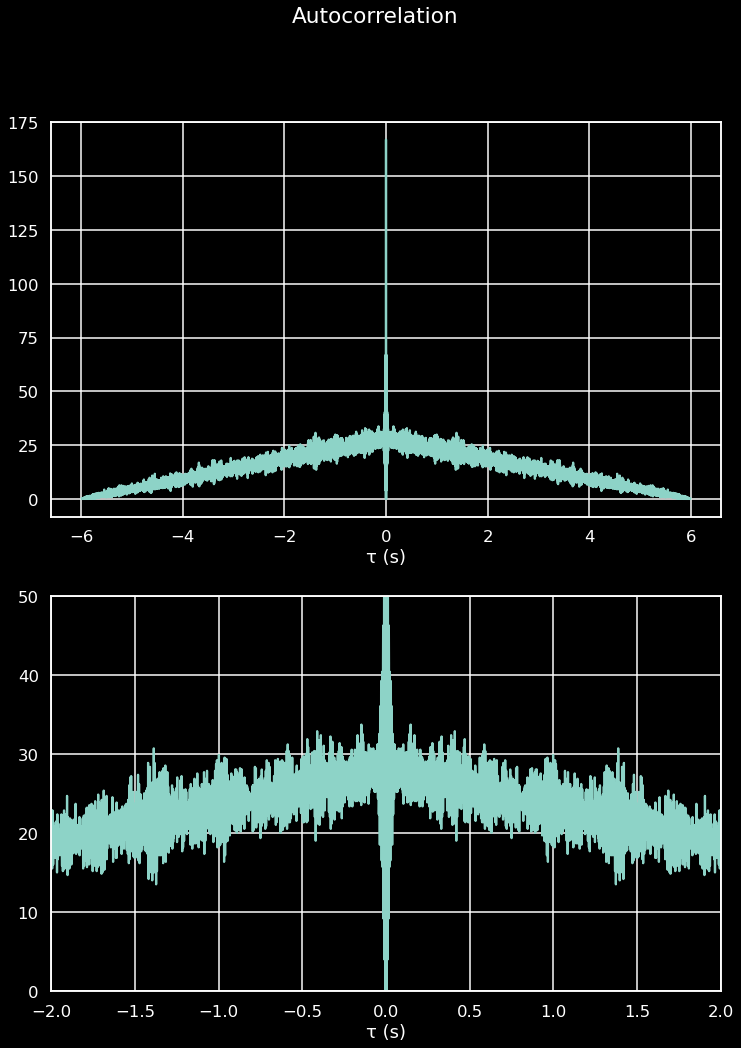

In [92]:
ylims = [0.5, 5, 10, 20, 40, 50]
for i,dirac in enumerate(ref_diracs):
    plot_autocorrelation(dirac, max_ts[i], ylim2 = ylims[i])

In [31]:
#plt.plot(ref_diracs[-1].ravel())
corr = np.correlate(ref_diracs[-1].ravel(), ref_diracs[-1].ravel(), 'same') / max_ts[-1]

In [21]:
ref_spike_times.shape

NameError: name 'ref_spike_times' is not defined

In [1]:
spike_trains[0]

NameError: name 'spike_trains' is not defined

In [30]:
hom_dirac.shape

(1, 98563)

In [31]:
inh_dirac.shape

(1, 201707)

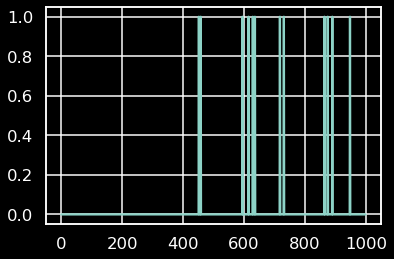

In [34]:
plt.plot(hom_dirac.T[:1000])

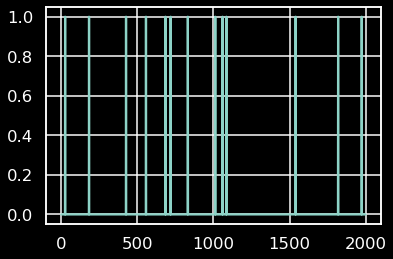

In [38]:
plt.plot(ref_diracs[0].T[:2000])

In [40]:
ref_diracs[-1].shape

(1, 5988)

In [57]:
a = ref_diracs[-1].ravel()[:5000]

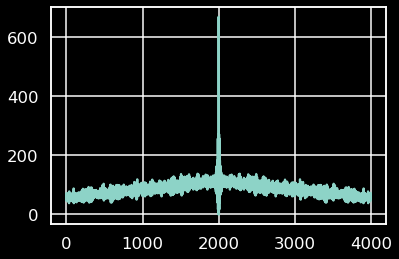

In [56]:
b = np.correlate(a, a, 'same')
plt.plot(b)